Stochastic Variational Bayes
=======================

This notebook implements Example 1 from the FMRIB tutorial on Variational Bayes II: Stochastic Variational Bayes ("fitting a Gaussian distribution).

We assume we have data drawn from a Gaussian distribution with true mean $\mu$ and true precision $\beta$:

$$
P(y_n | \mu, \beta) = \frac{\sqrt{\beta}}{\sqrt{2\pi}} \exp{-\frac{\beta}{2} (y_n - \mu)^2}
$$

One interpretation of this is that our data consists of repeated measurements of a fixed value ($\mu$) combined with Gaussian noise with standard deviation $\frac{1}{\sqrt{\beta}}$.

Here's how we can generate some sample data from this model in Python:

In [264]:
import numpy as np

# Ground truth parameters
# We infer the precision, BETA, but it is useful to
# derive the variance and standard deviation from it
MU_TRUTH = 42
BETA_TRUTH = 1.0
VAR_TRUTH = 1/BETA_TRUTH
STD_TRUTH = np.sqrt(VAR_TRUTH)

# Observed data samples are generated by Numpy from the ground truth
# Gaussian distribution. Reducing the number of samples should make
# the inference less 'confident' - i.e. the output variances for
# MU and BETA will increase
N = 100
DATA = np.random.normal(MU_TRUTH, STD_TRUTH, [N])
print("Data samples are:")
print(DATA)

Data samples are:
[40.2328132  43.40136723 42.40788925 42.86435462 42.85692771 42.4215073
 39.2661518  43.05464827 41.62784546 41.12849836 42.29329825 40.73027047
 42.55705207 42.53059286 43.25351173 41.99180284 39.59437436 43.84228782
 42.81904108 43.20391451 40.42690188 41.50148988 42.34446355 43.30752749
 41.14874263 41.19369615 42.82075653 42.70938028 42.4152085  40.68733998
 43.14623958 40.75756913 43.08115532 43.35669472 41.79253258 41.81525521
 43.02109031 42.73375903 42.41881117 41.39178314 43.6738212  43.00530613
 42.38298511 40.12215351 43.61384393 41.24011035 41.21269877 40.86346122
 41.88973243 41.19237744 43.4187467  42.39847176 42.29668236 42.19877576
 40.81233252 40.06956342 42.28522632 42.93930827 42.28664214 42.77924464
 41.89056314 43.59060333 41.38067394 42.42931232 42.41534059 41.39576908
 40.75275792 43.21334128 41.02078148 43.61360624 39.96579565 42.58695237
 40.89601238 42.34559584 41.67070605 41.31717269 41.63836307 41.49890191
 41.16645824 42.39136663 42.458786

As with analytic Variational Bayes, we need to choose an approximate form for our priors and posteriors. However we have more freedom in the stochastic method since we are not limited by the requirement that the distributions be conjugate with respect to the likelihood. 

We will choose a multivariate normal distribution (MVN) over the two parameters $\mu$ and $log(\frac{1}{\beta}$ for prior and posterior. Inferring the log of the noise variance is useful as it avoid the possibility of negative values during the optimization which would make the likelihood ill-defined.

The choice of an MVN means that we can allow for covariance (correlation) between the noise and signal parameters. This is unlike the analytic case where the posterior had to be factorised over these two parameters.

An MVN distribution for $N$ parameters is defined by a vector of $N$ mean values and an $N \times N$ covariance matrix. For the prior we will use the following values:

$$\textbf{m}_0 = \begin{bmatrix} \mu_0 \\ b_0 \end{bmatrix}$$

$$\textbf{C}_0 = \begin{bmatrix} v_0 & 0 \\ 0 & w_0 \end{bmatrix}$$

Note that we are not assuming any prior covariance. 

We define some suitable relatively uninformative prior values here:

In [265]:
m0 = 0.0
v0 = 100000.0
b0 = 0.0
w0 = 100000.0
print("Priors: P(mu, log(1/beta)) = MVN([%f, %f], [[%f, 0], [0, %f]])" % (m0, v0, b0, w0))

Priors: P(mu, log(1/beta)) = MVN([0.000000, 100000.000000], [[0.000000, 0], [0, 100000.000000]])


Stochastic VB is based around minimising the free energy so we will need to implement the calculation of the free energy. We will be using the TensorFlow framework to perform the minimisation so the calculation must be in terms of tensors (multidimensional arrays). In our case the following constant tensors must be defined (where $N$ is the number of data values we have:

 - Data samples: $[N]$
 - Prior mean: $[2]$
 - Prior covariance: $[2 \times 2]$

We must also define *variable* tensors for the posterior - TensorFlow will allow these to change during the optimization in order to minimise the cost (free energy):

 - Posterior mean: $[2]$
 - Posterior covariance: $[2 \times 2]$

The posterior covariance must be a positive-definite matrix - since the optimizer does not know this, it is possible that invalid values may arise and the optimization will fail. To get around this restriction we build the covariance matrix from its Chlolesky decomposition.

$$\textbf{C} = (\textbf{C}_{chol})^T\textbf{C}_{chol}$$

$\textbf{C}_{chol}$ must have positive diagonal elements, so we define the underlying variables for these elements in terms of the log and then form the full $\textbf{C}_{chol}$ matrix as a sum of the exponentials of the log-diagonal elements, and independent variables for the off-diagonal components.

The code for this is below. Note that we need to define initial values for the posterior variables. It turns out that in the stochastic method it is important that the initial poster variance is not too large so although the prior is not informative, the initial posterior is. 

In [266]:
import tensorflow as tf
import numpy as np
data = tf.constant(DATA, dtype=tf.float32)
prior_means = tf.constant([m0, v0], dtype=tf.float32)
prior_covariance = tf.constant([[v0, 0.0], [0.0, w0]], dtype=tf.float32)

post_means_init = [0.0, 0.0]
post_covariance_init = [[1.0, 0.0], [0.0, 1.0]]

chol_off_diag = tf.Variable([[0, 0], [0, 0]], dtype=tf.float32)
chol_log_diag = tf.Variable(tf.log(tf.diag_part(post_covariance_init)), dtype=tf.float32)
chol_diag = tf.diag(tf.sqrt(tf.exp(chol_log_diag)))
post_covariance_chol = tf.add(chol_diag, tf.matrix_band_part(chol_off_diag, -1, 0))

post_covariance = tf.matmul(tf.transpose(post_covariance_chol), post_covariance_chol)
post_means = tf.Variable(post_means_init, dtype=tf.float32)
  

At this point we will show how we actually evaluate calculations in TensorFlow. TensorFlow works by defining a graph of operations, but no calculation actually takes place until you ask it to evaluate a tensor (which might be defined in terms of other tensors or Variables. For example we can evaluate the inital values of our posterior as follows:

In [267]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())
print("Initial posterior mean: %s" % sess.run(post_means))
print("Initial posterior covariance:\n%s" % sess.run(post_covariance))

Initial posterior mean: [0. 0.]
Initial posterior covariance:
[[1. 0.]
 [0. 1.]]


The next requirement is to be able to obtain a sample of *predicted* data values from the posterior. In stochastic VB this is used to approximate the integrals in the calculation of the free energy. It is *not* related to the number of data samples we have. Smaller values give quicker calculation, but may result in a noisy, non-convergent optimization. We'll start off with a sample size of 5, but you can change this later if you want.

Note the use of the 'reparameterization trick' to express the samples as the scaling of a fixed MVN distribution - this improves the ability of the optimizer to choose better values for the next iteration.

In [268]:
# Number of samples from the posterior
S=5

# eps is a sample from a Gaussian with mean 0 and variance 1
eps = tf.random_normal((2, S), 0, 1, dtype=tf.float32)

# Start off each sample with the current posterior mean
# post_samples is now a tensor of shape [2, n_samples]
samples = tf.tile(tf.reshape(post_means, [2, 1]), [1, S])

# Now add the random sample scaled by the covariance
post_samples = tf.add(samples, tf.matmul(post_covariance_chol, eps))


Let's see how this works by evaluating a sample on our initial posterior

In [269]:
print(sess.run(post_samples))

[[ 0.26879016 -0.21093225  0.1460788   1.4760448  -1.3123885 ]
 [-1.5922093  -0.89369386 -0.40336815  1.3790154  -1.1314179 ]]


Note that we have 5 samples for each of the two parameters - the top row are samples values for $\mu$ and the bottom row are samples of the noise log variance $-\log{\beta}$.

Next we need to implement the free energy calculation. This is the sum of the reconstruction loss (the extent to which the posterior matches the data) and the latent loss (the extent to which the posterior matches the prior). Let's do the reconstruction loss first which is the expected value of the log-likelihood across the posterior distribution. Remember that the expectation integral is being approximated using the samples we have from the posterior.

In [305]:
# These are out sample of values for the mu parameter
mu_samples = post_samples[0]

# Get the current estimate of the noise variance 1/beta remembering that
# we are inferring the log of the noise variance
log_noise = post_samples[1]
noise_var = tf.exp(log_noise)

# Each sample value predicts the full set of values in the data sample.
# For our constant-signal model, the prediction is simply a set of 
# constant values. The prediction tensor will have shape [S, N]
# where S is the sample size and N is the number of data values
prediction = tf.tile(tf.reshape(mu_samples, [S, 1]), [1, N])

# To calculate the likelihood we need the sum of the squared difference between the data  
# and the prediction. This gives a value for each posterior sample so has shape [S]
sum_square_diff = tf.reduce_sum(tf.square(data - prediction), axis=-1)

# Now we calculate the likelihood for each posterior sample (shape [S])
# Note that we are ignoring constant factors such as 2*PI here as they 
# are just an fixed offset and do not affect the optimization 
log_likelihood = 0.5 * (log_noise * tf.to_float(N) + sum_square_diff / noise_var)

# Finally to evaluate the expectation value we take the mean across all the posterior
# samples
reconstr_loss = tf.reduce_mean(log_likelihood)


In [271]:
print("Reconstruction loss is: %f" % sess.run(reconstr_loss))

Reconstruction loss is: 160557.328125


On to the latent loss, this is the log-KL divergence between the posterior and prior. Since
both our prior and posterior are MVN distributions, we can use a known analytic result as
given in the tutorial

In [272]:
C = post_covariance
C0 = prior_covariance
C0_inv = tf.matrix_inverse(C0)

# m - m0 as row and column vectors
m_minus_m0 = tf.reshape(tf.subtract(post_means, prior_means), [-1, 1])
m_minus_m0_T = tf.reshape(tf.subtract(post_means, prior_means), [1, -1])


term1 = tf.trace(tf.matmul(C0_inv, C))
term2 = -tf.log(tf.matrix_determinant(C) / tf.matrix_determinant(C0))

# Size of the MVN distribution
term3 = -2
term4 = tf.matmul(tf.matmul(m_minus_m0_T, C0_inv), m_minus_m0)
          
latent_loss = 0.5 * (term1 + term2 + term3 + term4)


In [273]:
print("Latent loss is: %f" % sess.run(latent_loss))

Latent loss is: 50010.511719


Note that if you re-evaluate the reconstruction loss you get a different answer each time - because it depends on the sample from the posterior. But the latent loss is being calculated analytically and is independent of the sample, so we get the same answer each time.

(If you increase the posterior sample size you will get a more consistent value of the reconstruction loss - try it!)

Now we define the total cost (free energy) as the sum of the latent and reconstruction costs:

In [274]:
cost = reconstr_loss + latent_loss
print("Total cost is: %f" % sess.run(cost))

Total cost is: 173370.406250


To optimize the posterior we need to iteratively minimise the cost using TensorFlow's built in gradient optimizer. We use the Adam optimizer for this, which is a refinement of the standard Gradient Descent optimizer. 


In [297]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.5)
minimizer = optimizer.minimize(cost)
sess.run(tf.global_variables_initializer())

cost_history = []
for epoch in range(5000):
    sess.run(minimizer)
    cost_history.append(float(sess.run(cost)))
    print("Epoch %i: cost=%f, posterior means=%s" % (epoch+1, sess.run(cost), sess.run(post_means)))

Epoch 1: cost=91530.101562, posterior means=[0.5 0.5]
Epoch 2: cost=96729.304688, posterior means=[0.94287336 0.9438343 ]
Epoch 3: cost=73305.203125, posterior means=[1.3613689 1.36402  ]
Epoch 4: cost=69443.187500, posterior means=[1.7784123 1.7856473]
Epoch 5: cost=58245.070312, posterior means=[2.1831865 2.193902 ]
Epoch 6: cost=55654.445312, posterior means=[2.5545666 2.5691736]
Epoch 7: cost=54314.312500, posterior means=[2.8827076 2.9003804]
Epoch 8: cost=56170.160156, posterior means=[3.1786213 3.1984813]
Epoch 9: cost=52777.781250, posterior means=[3.44477   3.4661858]
Epoch 10: cost=51744.343750, posterior means=[3.6866398 3.7091267]
Epoch 11: cost=52460.367188, posterior means=[3.9087431 3.9318383]
Epoch 12: cost=50901.613281, posterior means=[4.1134396 4.136748 ]
Epoch 13: cost=50696.078125, posterior means=[4.299626 4.322904]
Epoch 14: cost=50882.667969, posterior means=[4.4700484 4.493106 ]
Epoch 15: cost=50872.062500, posterior means=[4.625349 4.648024]
Epoch 16: cost=508

Epoch 223: cost=50419.132812, posterior means=[7.067305 6.650862]
Epoch 224: cost=50418.183594, posterior means=[7.071876 6.6525  ]
Epoch 225: cost=50414.937500, posterior means=[7.076462 6.654145]
Epoch 226: cost=50413.691406, posterior means=[7.081013  6.6557403]
Epoch 227: cost=50410.015625, posterior means=[7.08551  6.657279]
Epoch 228: cost=50418.367188, posterior means=[7.090079 6.658891]
Epoch 229: cost=50415.796875, posterior means=[7.0946584 6.660505 ]
Epoch 230: cost=50413.796875, posterior means=[7.0991955 6.6620727]
Epoch 231: cost=50422.636719, posterior means=[7.1037984 6.663683 ]
Epoch 232: cost=50418.378906, posterior means=[7.1083703 6.6652603]
Epoch 233: cost=50412.191406, posterior means=[7.1130304 6.666908 ]
Epoch 234: cost=50423.492188, posterior means=[7.1177406 6.6685863]
Epoch 235: cost=50418.976562, posterior means=[7.12245  6.670259]
Epoch 236: cost=50411.500000, posterior means=[7.1270995 6.671876 ]
Epoch 237: cost=50418.621094, posterior means=[7.1316857 6.6

Epoch 468: cost=50407.550781, posterior means=[8.214812 6.907851]
Epoch 469: cost=50405.585938, posterior means=[8.219724  6.9084153]
Epoch 470: cost=50401.554688, posterior means=[8.224655  6.9089823]
Epoch 471: cost=50405.175781, posterior means=[8.229619 6.909588]
Epoch 472: cost=50411.734375, posterior means=[8.234624 6.910224]
Epoch 473: cost=50408.570312, posterior means=[8.239554 6.910802]
Epoch 474: cost=50405.171875, posterior means=[8.244512 6.911392]
Epoch 475: cost=50407.777344, posterior means=[8.2494335 6.9119434]
Epoch 476: cost=50407.562500, posterior means=[8.25435   6.9124837]
Epoch 477: cost=50406.753906, posterior means=[8.259262 6.913001]
Epoch 478: cost=50407.773438, posterior means=[8.264198 6.91353 ]
Epoch 479: cost=50406.433594, posterior means=[8.269116  6.9140534]
Epoch 480: cost=50406.421875, posterior means=[8.274037  6.9145665]
Epoch 481: cost=50410.824219, posterior means=[8.278973 6.915074]
Epoch 482: cost=50407.722656, posterior means=[8.283975  6.91562

Epoch 673: cost=50406.878906, posterior means=[9.298247  6.9813795]
Epoch 674: cost=50407.000000, posterior means=[9.303786  6.9814153]
Epoch 675: cost=50403.367188, posterior means=[9.309285 6.981401]
Epoch 676: cost=50407.621094, posterior means=[9.314817  6.9813905]
Epoch 677: cost=50402.179688, posterior means=[9.320455  6.9814615]
Epoch 678: cost=50401.578125, posterior means=[9.326101  6.9815307]
Epoch 679: cost=50402.835938, posterior means=[9.331799 6.981631]
Epoch 680: cost=50407.917969, posterior means=[9.337511  6.9817634]
Epoch 681: cost=50406.687500, posterior means=[9.343252 6.981905]
Epoch 682: cost=50397.308594, posterior means=[9.348982 6.98204 ]
Epoch 683: cost=50403.746094, posterior means=[9.354727 6.982157]
Epoch 684: cost=50405.652344, posterior means=[9.360453 6.982247]
Epoch 685: cost=50405.375000, posterior means=[9.36618   6.9823265]
Epoch 686: cost=50405.976562, posterior means=[9.37193  6.982425]
Epoch 687: cost=50405.632812, posterior means=[9.377664 6.9825

Epoch 898: cost=50398.617188, posterior means=[10.689839  6.96442 ]
Epoch 899: cost=50390.082031, posterior means=[10.696696   6.9642177]
Epoch 900: cost=50396.707031, posterior means=[10.703646  6.96408 ]
Epoch 901: cost=50403.085938, posterior means=[10.710646   6.9639535]
Epoch 902: cost=50400.781250, posterior means=[10.717644   6.9638114]
Epoch 903: cost=50392.964844, posterior means=[10.724608   6.9636416]
Epoch 904: cost=50393.453125, posterior means=[10.731549   6.9634423]
Epoch 905: cost=50397.121094, posterior means=[10.738562  6.963307]
Epoch 906: cost=50404.625000, posterior means=[10.745537   6.9631405]
Epoch 907: cost=50397.203125, posterior means=[10.752482  6.962954]
Epoch 908: cost=50402.480469, posterior means=[10.759434   6.9627466]
Epoch 909: cost=50404.757812, posterior means=[10.766339   6.9625564]
Epoch 910: cost=50400.312500, posterior means=[10.7732315  6.9623504]
Epoch 911: cost=50405.015625, posterior means=[10.780146  6.962141]
Epoch 912: cost=50392.750000, 

Epoch 1129: cost=50390.527344, posterior means=[12.429181   6.8839183]
Epoch 1130: cost=50389.921875, posterior means=[12.437511   6.8833613]
Epoch 1131: cost=50396.093750, posterior means=[12.445742   6.8827252]
Epoch 1132: cost=50393.468750, posterior means=[12.454038   6.8821187]
Epoch 1133: cost=50392.980469, posterior means=[12.462331  6.881538]
Epoch 1134: cost=50390.562500, posterior means=[12.470549  6.880948]
Epoch 1135: cost=50394.656250, posterior means=[12.478807  6.880405]
Epoch 1136: cost=50395.492188, posterior means=[12.486977   6.8798065]
Epoch 1137: cost=50389.546875, posterior means=[12.495202  6.879247]
Epoch 1138: cost=50404.460938, posterior means=[12.503482   6.8787146]
Epoch 1139: cost=50395.359375, posterior means=[12.511801  6.878179]
Epoch 1140: cost=50396.128906, posterior means=[12.520178  6.877693]
Epoch 1141: cost=50391.437500, posterior means=[12.528494   6.8771367]
Epoch 1142: cost=50392.101562, posterior means=[12.536882  6.876633]
Epoch 1143: cost=503

Epoch 1255: cost=50377.562500, posterior means=[13.53439   6.808934]
Epoch 1256: cost=50380.519531, posterior means=[13.543739   6.8084507]
Epoch 1257: cost=50381.863281, posterior means=[13.553197   6.8080077]
Epoch 1258: cost=50392.738281, posterior means=[13.562812   6.8076215]
Epoch 1259: cost=50384.855469, posterior means=[13.572477   6.8072395]
Epoch 1260: cost=50392.332031, posterior means=[13.582098  6.806808]
Epoch 1261: cost=50386.187500, posterior means=[13.591618   6.8063035]
Epoch 1262: cost=50390.187500, posterior means=[13.601118   6.8057113]
Epoch 1263: cost=50396.503906, posterior means=[13.610648   6.8051558]
Epoch 1264: cost=50382.105469, posterior means=[13.6201515  6.804599 ]
Epoch 1265: cost=50398.074219, posterior means=[13.629634   6.8040376]
Epoch 1266: cost=50385.429688, posterior means=[13.639156   6.8034773]
Epoch 1267: cost=50376.363281, posterior means=[13.648765   6.8029356]
Epoch 1268: cost=50388.351562, posterior means=[13.658475  6.802486]
Epoch 1269: 

Epoch 1480: cost=50379.566406, posterior means=[15.889378   6.6538463]
Epoch 1481: cost=50378.425781, posterior means=[15.900975  6.653045]
Epoch 1482: cost=50384.199219, posterior means=[15.912845  6.652321]
Epoch 1483: cost=50384.718750, posterior means=[15.924589   6.6516075]
Epoch 1484: cost=50376.226562, posterior means=[15.936342  6.650855]
Epoch 1485: cost=50375.363281, posterior means=[15.948073  6.650103]
Epoch 1486: cost=50382.121094, posterior means=[15.959937  6.649288]
Epoch 1487: cost=50376.746094, posterior means=[15.97178   6.648432]
Epoch 1488: cost=50374.687500, posterior means=[15.9836035  6.6476235]
Epoch 1489: cost=50382.363281, posterior means=[15.9954815  6.646784 ]
Epoch 1490: cost=50380.906250, posterior means=[16.007313   6.6459446]
Epoch 1491: cost=50385.898438, posterior means=[16.019161   6.6451077]
Epoch 1492: cost=50379.042969, posterior means=[16.030865   6.6442385]
Epoch 1493: cost=50381.378906, posterior means=[16.042387  6.643217]
Epoch 1494: cost=503

Epoch 1672: cost=50370.664062, posterior means=[18.361588   6.4563603]
Epoch 1673: cost=50355.925781, posterior means=[18.375685  6.454889]
Epoch 1674: cost=50373.894531, posterior means=[18.389978  6.453491]
Epoch 1675: cost=50368.113281, posterior means=[18.404413   6.4521317]
Epoch 1676: cost=50364.156250, posterior means=[18.418934  6.450641]
Epoch 1677: cost=50383.371094, posterior means=[18.433332   6.4491315]
Epoch 1678: cost=50370.175781, posterior means=[18.447851  6.447852]
Epoch 1679: cost=50369.996094, posterior means=[18.462418  6.446509]
Epoch 1680: cost=50365.035156, posterior means=[18.47697   6.445131]
Epoch 1681: cost=50376.414062, posterior means=[18.491459  6.443678]
Epoch 1682: cost=50354.992188, posterior means=[18.506182   6.4423213]
Epoch 1683: cost=50391.820312, posterior means=[18.521013   6.4410458]
Epoch 1684: cost=50380.863281, posterior means=[18.53606   6.439753]
Epoch 1685: cost=50385.359375, posterior means=[18.550978   6.4384933]
Epoch 1686: cost=50353

Epoch 1847: cost=50352.351562, posterior means=[21.094046  6.193157]
Epoch 1848: cost=50326.894531, posterior means=[21.110802   6.1913137]
Epoch 1849: cost=50356.105469, posterior means=[21.127316   6.1894774]
Epoch 1850: cost=50311.453125, posterior means=[21.143362   6.1876173]
Epoch 1851: cost=50350.558594, posterior means=[21.15943  6.18575]
Epoch 1852: cost=50370.679688, posterior means=[21.175184   6.1838274]
Epoch 1853: cost=50374.031250, posterior means=[21.190989  6.181862]
Epoch 1854: cost=50344.449219, posterior means=[21.207079  6.179822]
Epoch 1855: cost=50351.730469, posterior means=[21.223316   6.1777515]
Epoch 1856: cost=50348.046875, posterior means=[21.239836   6.1757584]
Epoch 1857: cost=50369.101562, posterior means=[21.256985  6.173781]
Epoch 1858: cost=50369.601562, posterior means=[21.274527  6.171735]
Epoch 1859: cost=50336.531250, posterior means=[21.29175    6.1698146]
Epoch 1860: cost=50330.105469, posterior means=[21.309462  6.168077]
Epoch 1861: cost=50370

Epoch 2035: cost=50251.964844, posterior means=[24.590824  5.792062]
Epoch 2036: cost=50330.343750, posterior means=[24.614002   5.7894197]
Epoch 2037: cost=50336.277344, posterior means=[24.636974  5.786611]
Epoch 2038: cost=50346.882812, posterior means=[24.655313  5.784689]
Epoch 2039: cost=50369.472656, posterior means=[24.673958   5.7827077]
Epoch 2040: cost=50300.203125, posterior means=[24.693014   5.7806478]
Epoch 2041: cost=50310.992188, posterior means=[24.712757  5.778393]
Epoch 2042: cost=50326.007812, posterior means=[24.732706   5.7762914]
Epoch 2043: cost=50367.003906, posterior means=[24.752663  5.774231]
Epoch 2044: cost=50350.324219, posterior means=[24.772968  5.772048]
Epoch 2045: cost=50342.148438, posterior means=[24.793474   5.7697964]
Epoch 2046: cost=50325.753906, posterior means=[24.813074   5.7673173]
Epoch 2047: cost=50365.531250, posterior means=[24.833578   5.7648973]
Epoch 2048: cost=50299.468750, posterior means=[24.85395   5.762479]
Epoch 2049: cost=502

Epoch 2250: cost=50280.796875, posterior means=[29.864235   5.1870723]
Epoch 2251: cost=50332.863281, posterior means=[29.891317   5.1837974]
Epoch 2252: cost=50267.902344, posterior means=[29.918142  5.180418]
Epoch 2253: cost=50254.199219, posterior means=[29.94455  5.17685]
Epoch 2254: cost=50286.148438, posterior means=[29.970985   5.1730576]
Epoch 2255: cost=50325.789062, posterior means=[29.99895    5.1695075]
Epoch 2256: cost=50327.406250, posterior means=[30.026924   5.1659307]
Epoch 2257: cost=50261.128906, posterior means=[30.048296  5.163107]
Epoch 2258: cost=50219.785156, posterior means=[30.071701   5.1604085]
Epoch 2259: cost=50230.519531, posterior means=[30.095894   5.1573615]
Epoch 2260: cost=50306.839844, posterior means=[30.121645  5.154454]
Epoch 2261: cost=50321.726562, posterior means=[30.146307  5.151324]
Epoch 2262: cost=50296.308594, posterior means=[30.171585  5.148249]
Epoch 2263: cost=50320.343750, posterior means=[30.199993   5.1452456]
Epoch 2264: cost=503

Epoch 2448: cost=50246.894531, posterior means=[36.4841     4.1164474]
Epoch 2449: cost=50215.160156, posterior means=[36.51755    4.1086183]
Epoch 2450: cost=50260.097656, posterior means=[36.55205   4.100725]
Epoch 2451: cost=50216.351562, posterior means=[36.58677   4.092631]
Epoch 2452: cost=50212.433594, posterior means=[36.62219   4.084457]
Epoch 2453: cost=50259.687500, posterior means=[36.657513   4.0761485]
Epoch 2454: cost=50261.625000, posterior means=[36.69369    4.0678325]
Epoch 2455: cost=50271.468750, posterior means=[36.73012   4.059471]
Epoch 2456: cost=50248.992188, posterior means=[36.76869   4.051201]
Epoch 2457: cost=50199.468750, posterior means=[36.808067   4.0428724]
Epoch 2458: cost=50199.257812, posterior means=[36.847977  4.034563]
Epoch 2459: cost=50246.414062, posterior means=[36.884068   4.0261526]
Epoch 2460: cost=50234.562500, posterior means=[36.921337   4.0177054]
Epoch 2461: cost=50225.449219, posterior means=[36.95943    4.0091777]
Epoch 2462: cost=5

Epoch 2663: cost=50109.261719, posterior means=[41.874928   1.7400872]
Epoch 2664: cost=50094.730469, posterior means=[41.873425   1.7272906]
Epoch 2665: cost=50111.113281, posterior means=[41.873497   1.7144226]
Epoch 2666: cost=50100.890625, posterior means=[41.874073  1.70159 ]
Epoch 2667: cost=50096.320312, posterior means=[41.875057   1.6888435]
Epoch 2668: cost=50109.289062, posterior means=[41.87727    1.6759875]
Epoch 2669: cost=50109.933594, posterior means=[41.880707   1.6630782]
Epoch 2670: cost=50111.164062, posterior means=[41.88338    1.6502366]
Epoch 2671: cost=50111.871094, posterior means=[41.886856   1.6374336]
Epoch 2672: cost=50107.035156, posterior means=[41.877926   1.6252079]
Epoch 2673: cost=50093.003906, posterior means=[41.870293   1.6129771]
Epoch 2674: cost=50096.523438, posterior means=[41.8651     1.6006947]
Epoch 2675: cost=50118.312500, posterior means=[41.862415   1.5882802]
Epoch 2676: cost=50107.265625, posterior means=[41.861538   1.5758481]
Epoch 26

Epoch 2827: cost=50067.585938, posterior means=[41.997013    0.25601333]
Epoch 2828: cost=50067.031250, posterior means=[41.99751    0.2518527]
Epoch 2829: cost=50064.968750, posterior means=[41.99876     0.24757445]
Epoch 2830: cost=50066.742188, posterior means=[42.007774    0.24330315]
Epoch 2831: cost=50065.933594, posterior means=[42.003963    0.23939961]
Epoch 2832: cost=50067.183594, posterior means=[42.00365    0.2355395]
Epoch 2833: cost=50067.015625, posterior means=[42.001984    0.23162949]
Epoch 2834: cost=50068.300781, posterior means=[41.998226    0.22775131]
Epoch 2835: cost=50067.886719, posterior means=[41.994526    0.22381827]
Epoch 2836: cost=50067.000000, posterior means=[41.993332    0.21998483]
Epoch 2837: cost=50066.816406, posterior means=[41.99381     0.21606983]
Epoch 2838: cost=50066.695312, posterior means=[41.991707    0.21218255]
Epoch 2839: cost=50066.761719, posterior means=[41.98755    0.2085577]
Epoch 2840: cost=50066.328125, posterior means=[41.982956

Epoch 3055: cost=50066.234375, posterior means=[4.2014191e+01 4.0505588e-02]
Epoch 3056: cost=50065.460938, posterior means=[4.2036495e+01 4.0039927e-02]
Epoch 3057: cost=50065.785156, posterior means=[4.205329e+01 3.948849e-02]
Epoch 3058: cost=50066.414062, posterior means=[4.2058395e+01 3.9103117e-02]
Epoch 3059: cost=50065.699219, posterior means=[4.205407e+01 3.908483e-02]
Epoch 3060: cost=50066.058594, posterior means=[4.2047508e+01 3.9024223e-02]
Epoch 3061: cost=50065.921875, posterior means=[4.2036934e+01 3.9032575e-02]
Epoch 3062: cost=50065.824219, posterior means=[4.2021549e+01 3.9125945e-02]
Epoch 3063: cost=50065.539062, posterior means=[4.2004791e+01 3.9040104e-02]
Epoch 3064: cost=50065.617188, posterior means=[4.199285e+01 3.891521e-02]
Epoch 3065: cost=50065.992188, posterior means=[4.1985268e+01 3.8799573e-02]
Epoch 3066: cost=50065.886719, posterior means=[4.197683e+01 3.846982e-02]
Epoch 3067: cost=50065.417969, posterior means=[4.1975277e+01 3.8069759e-02]
Epoch 3

Epoch 3182: cost=50065.191406, posterior means=[4.2024593e+01 3.2885026e-02]
Epoch 3183: cost=50065.648438, posterior means=[4.2029514e+01 3.2897715e-02]
Epoch 3184: cost=50064.949219, posterior means=[4.2030281e+01 3.2811973e-02]
Epoch 3185: cost=50065.378906, posterior means=[4.2028175e+01 3.2769751e-02]
Epoch 3186: cost=50066.160156, posterior means=[4.2024010e+01 3.2705802e-02]
Epoch 3187: cost=50066.914062, posterior means=[4.2017883e+01 3.2926030e-02]
Epoch 3188: cost=50067.082031, posterior means=[4.2004517e+01 3.3203457e-02]
Epoch 3189: cost=50065.542969, posterior means=[4.1996994e+01 3.3244468e-02]
Epoch 3190: cost=50065.437500, posterior means=[4.1991802e+01 3.3178408e-02]
Epoch 3191: cost=50065.421875, posterior means=[4.1984707e+01 3.3323467e-02]
Epoch 3192: cost=50066.234375, posterior means=[4.1973133e+01 3.3148974e-02]
Epoch 3193: cost=50066.039062, posterior means=[4.1963543e+01 3.2759584e-02]
Epoch 3194: cost=50065.699219, posterior means=[4.1959099e+01 3.2458328e-02]

Epoch 3293: cost=50065.382812, posterior means=[42.006344    0.04608457]
Epoch 3294: cost=50065.691406, posterior means=[41.999897    0.04612951]
Epoch 3295: cost=50066.496094, posterior means=[41.991714    0.04606476]
Epoch 3296: cost=50066.972656, posterior means=[41.983963    0.04609816]
Epoch 3297: cost=50065.714844, posterior means=[41.97767     0.04611006]
Epoch 3298: cost=50065.613281, posterior means=[41.976097    0.04594699]
Epoch 3299: cost=50065.050781, posterior means=[41.991287    0.04604314]
Epoch 3300: cost=50068.101562, posterior means=[42.019505    0.04622847]
Epoch 3301: cost=50065.074219, posterior means=[42.033585    0.04636097]
Epoch 3302: cost=50067.515625, posterior means=[42.040142    0.04648484]
Epoch 3303: cost=50066.199219, posterior means=[42.054707    0.04644853]
Epoch 3304: cost=50065.488281, posterior means=[42.076454    0.04660049]
Epoch 3305: cost=50066.332031, posterior means=[42.0919      0.04650884]
Epoch 3306: cost=50067.011719, posterior means=[42.

Epoch 3514: cost=50065.773438, posterior means=[4.1964565e+01 3.7315983e-02]
Epoch 3515: cost=50065.472656, posterior means=[4.1973801e+01 3.7046254e-02]
Epoch 3516: cost=50064.824219, posterior means=[4.1987171e+01 3.6757663e-02]
Epoch 3517: cost=50065.207031, posterior means=[4.2004726e+01 3.6438163e-02]
Epoch 3518: cost=50065.250000, posterior means=[4.2009972e+01 3.5996713e-02]
Epoch 3519: cost=50065.507812, posterior means=[4.2012558e+01 3.5518456e-02]
Epoch 3520: cost=50065.996094, posterior means=[4.2010998e+01 3.4696687e-02]
Epoch 3521: cost=50065.539062, posterior means=[4.2007511e+01 3.4023996e-02]
Epoch 3522: cost=50065.414062, posterior means=[4.2000477e+01 3.3500511e-02]
Epoch 3523: cost=50065.660156, posterior means=[4.1994740e+01 3.3241194e-02]
Epoch 3524: cost=50065.230469, posterior means=[4.1987453e+01 3.2527145e-02]
Epoch 3525: cost=50065.082031, posterior means=[4.1976837e+01 3.1977385e-02]
Epoch 3526: cost=50066.382812, posterior means=[4.1971313e+01 3.1538177e-02]

Epoch 3624: cost=50065.847656, posterior means=[41.999756    0.04519796]
Epoch 3625: cost=50065.167969, posterior means=[42.020294    0.04614475]
Epoch 3626: cost=50065.265625, posterior means=[42.033947    0.04692458]
Epoch 3627: cost=50065.742188, posterior means=[42.044502    0.04771094]
Epoch 3628: cost=50065.203125, posterior means=[42.054585    0.04868415]
Epoch 3629: cost=50065.878906, posterior means=[42.06234     0.04955941]
Epoch 3630: cost=50067.289062, posterior means=[42.062305   0.0501152]
Epoch 3631: cost=50066.855469, posterior means=[42.058804    0.05043078]
Epoch 3632: cost=50065.867188, posterior means=[42.032715    0.05122997]
Epoch 3633: cost=50065.640625, posterior means=[42.006466    0.05209405]
Epoch 3634: cost=50065.472656, posterior means=[41.97273     0.05279304]
Epoch 3635: cost=50065.355469, posterior means=[41.935875    0.05339716]
Epoch 3636: cost=50065.878906, posterior means=[41.91239     0.05420971]
Epoch 3637: cost=50065.992188, posterior means=[41.89

Epoch 3813: cost=50070.128906, posterior means=[42.098       0.04605561]
Epoch 3814: cost=50079.742188, posterior means=[42.155643    0.04841669]
Epoch 3815: cost=50102.269531, posterior means=[42.188698    0.05375963]
Epoch 3816: cost=50079.179688, posterior means=[42.200733    0.05935138]
Epoch 3817: cost=50067.265625, posterior means=[42.1484      0.06540326]
Epoch 3818: cost=50065.886719, posterior means=[42.09724     0.07121763]
Epoch 3819: cost=50066.359375, posterior means=[42.04052     0.07667488]
Epoch 3820: cost=50068.472656, posterior means=[41.983715    0.08150432]
Epoch 3821: cost=50067.222656, posterior means=[41.935585    0.08651867]
Epoch 3822: cost=50067.875000, posterior means=[41.88009     0.09129935]
Epoch 3823: cost=50065.679688, posterior means=[41.834263    0.09584588]
Epoch 3824: cost=50067.378906, posterior means=[41.819305   0.1001917]
Epoch 3825: cost=50068.726562, posterior means=[41.835674    0.10438862]
Epoch 3826: cost=50065.804688, posterior means=[41.89

Epoch 4005: cost=50065.269531, posterior means=[42.00002     0.11714459]
Epoch 4006: cost=50066.773438, posterior means=[42.00771     0.11469925]
Epoch 4007: cost=50066.121094, posterior means=[42.01556     0.11234744]
Epoch 4008: cost=50067.937500, posterior means=[42.028183    0.10997774]
Epoch 4009: cost=50065.441406, posterior means=[42.019398    0.10818611]
Epoch 4010: cost=50065.847656, posterior means=[42.01764     0.10622036]
Epoch 4011: cost=50065.367188, posterior means=[42.01479     0.10368016]
Epoch 4012: cost=50066.664062, posterior means=[42.015186    0.10129911]
Epoch 4013: cost=50065.449219, posterior means=[42.010998    0.09896542]
Epoch 4014: cost=50065.589844, posterior means=[41.99982     0.09646286]
Epoch 4015: cost=50066.031250, posterior means=[41.995827    0.09372362]
Epoch 4016: cost=50065.632812, posterior means=[41.989536    0.09084739]
Epoch 4017: cost=50065.921875, posterior means=[41.975117    0.08815905]
Epoch 4018: cost=50065.625000, posterior means=[41.

Epoch 4232: cost=50067.671875, posterior means=[41.945415    0.32648554]
Epoch 4233: cost=50067.273438, posterior means=[41.958153    0.31955332]
Epoch 4234: cost=50067.410156, posterior means=[41.979507    0.31266785]
Epoch 4235: cost=50067.890625, posterior means=[42.002308    0.30546978]
Epoch 4236: cost=50069.792969, posterior means=[42.023983   0.2982578]
Epoch 4237: cost=50069.070312, posterior means=[42.04081     0.29106873]
Epoch 4238: cost=50067.605469, posterior means=[42.038383    0.28387365]
Epoch 4239: cost=50070.191406, posterior means=[42.03787     0.27691397]
Epoch 4240: cost=50067.738281, posterior means=[42.03601    0.2701052]
Epoch 4241: cost=50066.789062, posterior means=[41.996357    0.26424938]
Epoch 4242: cost=50067.144531, posterior means=[41.95642    0.2584831]
Epoch 4243: cost=50069.027344, posterior means=[41.92894     0.25266224]
Epoch 4244: cost=50068.710938, posterior means=[41.910824    0.24650162]
Epoch 4245: cost=50066.203125, posterior means=[41.890545

Epoch 4427: cost=50067.148438, posterior means=[42.022896    0.05306894]
Epoch 4428: cost=50065.886719, posterior means=[42.008232    0.05231314]
Epoch 4429: cost=50067.429688, posterior means=[42.01796     0.05177807]
Epoch 4430: cost=50070.207031, posterior means=[42.026024    0.05163416]
Epoch 4431: cost=50076.074219, posterior means=[42.013577    0.05144602]
Epoch 4432: cost=50081.675781, posterior means=[41.99933     0.05156001]
Epoch 4433: cost=50067.878906, posterior means=[41.96623     0.05252527]
Epoch 4434: cost=50071.050781, posterior means=[41.927288    0.05393359]
Epoch 4435: cost=50068.886719, posterior means=[41.858185    0.05547802]
Epoch 4436: cost=50067.792969, posterior means=[41.793182    0.05684251]
Epoch 4437: cost=50069.039062, posterior means=[41.789715    0.05846677]
Epoch 4438: cost=50068.167969, posterior means=[41.819576    0.05986989]
Epoch 4439: cost=50065.695312, posterior means=[41.872517    0.06100266]
Epoch 4440: cost=50077.136719, posterior means=[41.

Epoch 4634: cost=50065.234375, posterior means=[41.949318    0.04670825]
Epoch 4635: cost=50066.300781, posterior means=[41.907894    0.04701346]
Epoch 4636: cost=50065.738281, posterior means=[41.89745     0.04750102]
Epoch 4637: cost=50067.421875, posterior means=[41.912632    0.04851156]
Epoch 4638: cost=50066.355469, posterior means=[41.940098   0.0492484]
Epoch 4639: cost=50065.597656, posterior means=[41.973362    0.04950188]
Epoch 4640: cost=50066.058594, posterior means=[42.005405   0.0496785]
Epoch 4641: cost=50066.843750, posterior means=[42.035713    0.05014972]
Epoch 4642: cost=50065.476562, posterior means=[42.068768    0.05008107]
Epoch 4643: cost=50067.664062, posterior means=[42.037712    0.05131574]
Epoch 4644: cost=50068.582031, posterior means=[42.012897    0.05233015]
Epoch 4645: cost=50065.019531, posterior means=[41.987267    0.05310192]
Epoch 4646: cost=50065.351562, posterior means=[41.98227     0.05414137]
Epoch 4647: cost=50065.148438, posterior means=[41.9892

Epoch 4853: cost=50066.042969, posterior means=[4.2033382e+01 3.9895125e-02]
Epoch 4854: cost=50065.546875, posterior means=[4.2044018e+01 3.9809152e-02]
Epoch 4855: cost=50065.863281, posterior means=[4.2049507e+01 3.9755229e-02]
Epoch 4856: cost=50065.523438, posterior means=[4.2041687e+01 3.9358061e-02]
Epoch 4857: cost=50065.675781, posterior means=[4.2020657e+01 3.8871080e-02]
Epoch 4858: cost=50065.664062, posterior means=[4.1996254e+01 3.8307905e-02]
Epoch 4859: cost=50066.144531, posterior means=[4.1974220e+01 3.7648518e-02]
Epoch 4860: cost=50066.910156, posterior means=[4.1963360e+01 3.6872942e-02]
Epoch 4861: cost=50066.097656, posterior means=[4.1965012e+01 3.5718743e-02]
Epoch 4862: cost=50065.777344, posterior means=[4.1968704e+01 3.4506902e-02]
Epoch 4863: cost=50066.570312, posterior means=[4.1988903e+01 3.3868399e-02]
Epoch 4864: cost=50065.601562, posterior means=[4.1997574e+01 3.2850724e-02]
Epoch 4865: cost=50065.593750, posterior means=[4.2015392e+01 3.1793799e-02]

We should find our estimates for mu and beta are as expected, remembering that we chose
to estimate $-\log{\beta}$:

In [292]:
final_means = sess.run(post_means)
final_covariance = sess.run(post_covariance)
print("Estimate for mu: %f (variance: %f)" % (final_means[0], final_covariance[0, 0]))
print("Estimate for beta: %f" % np.exp(-final_means[1]))

Estimate for mu: 41.945972 (variance: 0.005239)
Estimate for beta: 0.962362


The convergence of the minimisation in this case is rather slow - considering the simplicity of the problem. This is partly due to the large difference between the initial posterior and the true value for $\mu$. However, frameworks like TensorFlow are not really optimized for inferring such a small number of parameters and the method. If we plot the cost history we can see that it gets stuck in a local minimum for some time:

(50000, 51000)

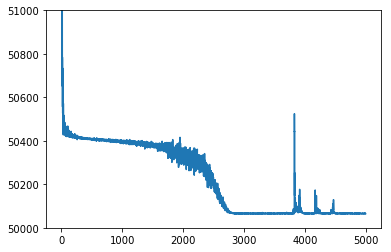

In [304]:
# from matplotlib import pyplot as plt
plt.plot(cost_history)
plt.ylim(50000, 51000)

The real advantage of the SVB approach is the flexibility - as well as losing the restriction to conjugate priors, it is also much easier to implement more advanced types of parameters and priors, for example global parameters or spatial regularization priors. While these can (and have been) incorporated into the analytic VB framework, they require update equations to be re-derived whereas the SVB method simply needs an expression for the cost which is generally more straightforward.